# Evaluation

# Setup

In [1]:
import pandas as pd
from pathlib import Path
import os
import sys
import time
import krippendorff
import matplotlib.pyplot as plt
import seaborn as sns
colours = sns.color_palette("Set2")
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
from sentence_transformers import SentenceTransformer

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from utils import get_table_from_supabase, extract_classifications
from evaluation_utils import get_recipients_by_id, format_tests
from evaluation_logic import *

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

----

# Retrieving Data from Checkpoints

In [2]:
#get checkpoint folder
checkpoint_folder = Path("./13.1_checkpoints/")

#get checkpoint
funders_df = pd.read_pickle(checkpoint_folder / "funders_df.pkl")
grants_df = pd.read_pickle(checkpoint_folder / "grants_df.pkl")
areas_df = pd.read_pickle(checkpoint_folder / "areas_df.pkl")
hierarchies_df = pd.read_pickle(checkpoint_folder / "hierarchies_df.pkl")
eval_df = pd.read_pickle(checkpoint_folder / "eval_df.pkl")

-----

# Retrieving Data from Supabase and Building Dataframes

I have imported the evaluation pairs dataframe that was built as part of the logic development, but it is missing data for rows where `is_recipient=False`. This is due to the way that the database was built; these charities had not been linked to any grants from the 360Giving API or extracted from accounts, so did not get fed through the entire database building process. I will run the same embedding and classification extraction processes for these rows that have been used for the user preparation in prior notebooks, to ensure that the evaluation funder-recipient pairs have all data necessary to calculate their alignment scores.

In [3]:
#get data for evaluation recipients
recipient_ids = eval_df["recipient_id"].unique()
recipients_df = get_recipients_by_id(url, key, recipient_ids)

## Creation of Embeddings

In [4]:
model = SentenceTransformer("all-roberta-large-v1")
recipient_cols = ["recipient_name", "recipient_activities", "recipient_objectives"]
recipients_false = recipients_df[recipients_df["is_recipient"] == False].copy()
recipients_false["recipient_concat_em"] = None

if len(recipients_false) > 0:
    for col in recipient_cols:
        #replace nans with empty string
        texts = recipients_false[col].fillna("").tolist()
        embeddings = model.encode(texts)

        #add to df
        recipients_false[f"{col}_em"] = list(embeddings)

    recipients_false["concat_text"] = recipients_false[recipient_cols[0]].fillna("")
    for col in recipient_cols[1:]:
        recipients_false["concat_text"] += " " + recipients_false[col].fillna("")

    #make lowercase
    recipients_false["concat_text"] = recipients_false["concat_text"].str.lower()

    #create embeddings
    texts = recipients_false["concat_text"].tolist()
    embeddings = model.encode(texts)
    recipients_false["recipient_concat_em"] = list(embeddings)

    #drop concatenated text
    recipients_false = recipients_false.drop(columns=["concat_text"])

    embedding_cols = [f"{col}_em" for col in recipient_cols] + ["recipient_concat_em"]
    for col in embedding_cols:
        recipients_false.loc[recipients_false["is_recipient"] == False, col] = recipients_false[col].values

## Creation of Extracted Classes

In [5]:
#load classifications data
ukcat_url = "https://raw.githubusercontent.com/lico27/ukcat/main/data/ukcat.csv"
ukcat_df = pd.read_csv(ukcat_url)

#define elements to process
recipient_sections = ["recipient_name", "recipient_objectives", "recipient_activities"]
keyword_data = [(recipients_false, recipient_sections, "recipient")]
recipients_false["extracted_class"] = recipients_false["recipient_areas"].copy()

#extract classifications
for df, sections, name in keyword_data:
    start_time = time.time()
    df["recipient_extracted_class"] = df.apply(lambda row: extract_classifications(row, sections, ukcat_df, areas_df), axis=1)
    elapsed_time = time.time() - start_time
    print(f"Classification extraction complete for {name}. Total time: {elapsed_time:.2f}s")

Classification extraction complete for recipient. Total time: 0.27s


In [6]:
#capitalise extracted classifications
recipients_false["recipient_extracted_class"] = recipients_false["recipient_extracted_class"].apply(lambda classifications: [phrase.upper() for phrase in classifications] if isinstance(classifications, list) else [])

#remove "grant making"
recipients_false["recipient_extracted_class"] = recipients_false["recipient_extracted_class"].apply(lambda classifications: [phrase for phrase in classifications if phrase != "GRANT MAKING"] if isinstance(classifications, list) else [])

#drop extra column
recipients_false = recipients_false.drop(columns=["extracted_class"])

## The Final Evaluation Pairs Dataframe

In [7]:
#remove rows with missing data and concat recipients dfs
recipients_df = recipients_df[~recipients_df["recipient_id"].isin(recipients_false["recipient_id"])]
recipients_df = pd.concat([recipients_df, recipients_false], ignore_index=True)

#drop old recipient cols and add new to eval_df
recipient_cols = [col for col in eval_df.columns if col.startswith("recipient_") and col != "recipient_id"]
eval_df = eval_df.drop(columns=recipient_cols)
eval_df = eval_df.merge(recipients_df, on="recipient_id", how="left")
eval_df = eval_df.rename(columns=lambda col: f"user_{col[len('recipient_'):]}" if col.startswith("recipient_") else col)

In [8]:
pd.set_option("display.max_columns", None)
eval_df.head(1)

,id,funder_registered_num,user_id,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_potential_sbf,is_on_list,is_nua,name_em,activities_em,objectives_em,objectives_activities_em,achievements_performance_em,grant_policy_em,concat_em,extracted_class,causes,areas,beneficiaries,income_history,expenditure_history,list_entries,user_name,user_activities,is_recipient,user_objectives,user_name_em,user_activities_em,user_objectives_em,user_concat_em,user_extracted_class,user_areas,user_causes,user_beneficiaries
0,1,298633,1207372,BACON CHARITABLE TRUST,None,MAKING DONATIONS TO SUCH CHARITABLE INSTITUTIO...,TO APPLY THE INCOME AND ALL OR SUCH PART OR PA...,72879.0,72879.0,None,None,None,False,False,False,"[0.004460917,0.035826597,-0.01591086,-0.011070...","[-0.0064024967,0.037508424,-0.0025785645,-0.02...","[-0.024516284,0.022869943,-0.032995474,-0.0348...","[-0.019817753,-0.00571729,0.022262126,-0.03666...","[-0.019817753,-0.00571729,0.022262126,-0.03666...","[-0.019817753,-0.00571729,0.022262126,-0.03666...","[-0.021681184,0.0020920401,0.009623636,-0.0578...","[""GRANT MAKING""]","[General Charitable Purposes, Environment/cons...","[Lincolnshire, Norfolk]",[Other Charities Or Voluntary Bodies],"{2020: 23696.0, 2021: 27920.0, 2022: 242325.0,...","{2020: 23696.0, 2021: 27920.0, 2022: 242325.0,...",[],CATTON GROVE COMMUNITY CENTRE CIO,CATTON GROVE COMMUNITY CENTRE SUPPORTS A WIDE ...,False,THE OBJECTS OF THE CIO ARE TO FURTHER BENEFIT ...,"[0.006319203, 0.0067654094, -0.029557364, -0.0...","[0.0027825288, -0.043152414, 0.016655156, -0.0...","[-0.011579754, 0.0077819657, -0.030523552, -0....","[-0.02640823, 0.0003374529, 0.019409541, -0.04...","[NORFOLK, COMMUNITY ASSOCIATION, COMMUNITY DEV...",[Norfolk],[Recreation],"[Children/young People, Elderly/old People, Pe..."


## Evaluation Responses

In [9]:
#get table from supabase
responses_df = get_table_from_supabase(url, key, "evaluation_responses")

#assign ids to respondents
responses_df["respondent_id"] = (responses_df["id"] - 61) // 3 + 1

----

# Exploration of Raters' Responses

To understand the level of agreement among raters for each funder-recipient pair, I will create a boxplot showing the distribution of ratings. This will allow me to identify which pairs generated strong consensus among professional fundraisers, offering insight into whether there is inter-rater agreement so that I can gauge the usefulness of the feedback in evaluating prospie's performance.

I will also calculate k-alpha for each pair (Krippendorff, 2019), which quantifies inter-rater reliability thereby indicating how consistent and useful the gathered evaluation data will be.

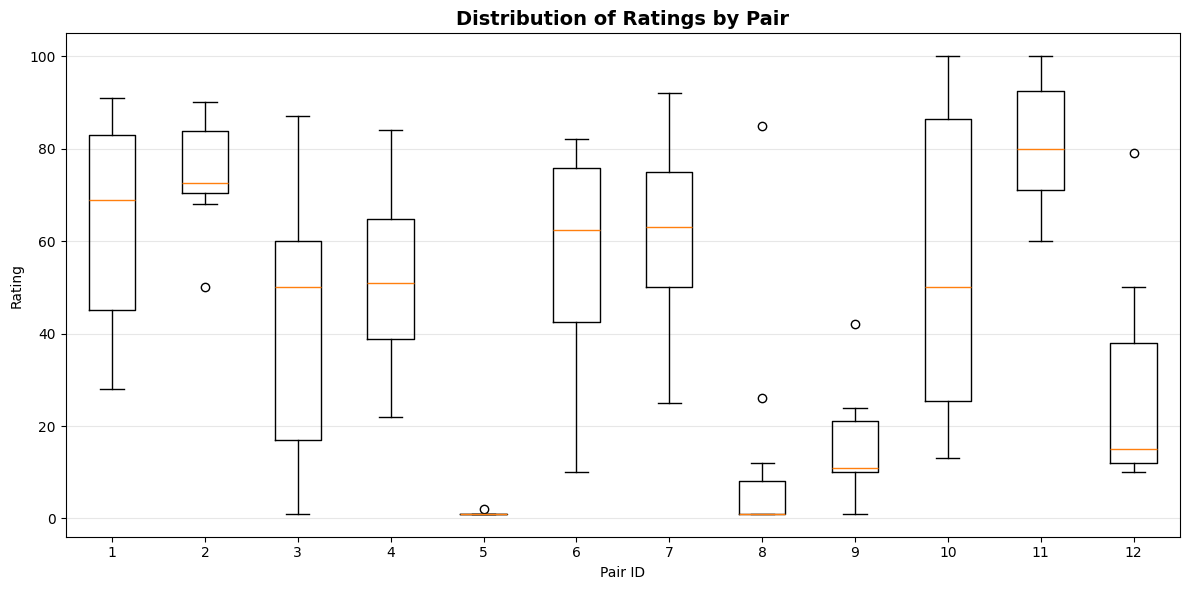

In [10]:
#group pairs
pair_ids = sorted(responses_df["pair_id"].unique())
data_by_pair = [responses_df[responses_df["pair_id"] == pair_id]["rating"].values for pair_id in pair_ids]

#create boxplot
fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(data_by_pair, labels=pair_ids, showfliers=True)

ax.set_title("Distribution of Ratings by Pair", fontsize=14, fontweight="bold")
ax.set_xlabel("Pair ID")
ax.set_ylabel("Rating")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

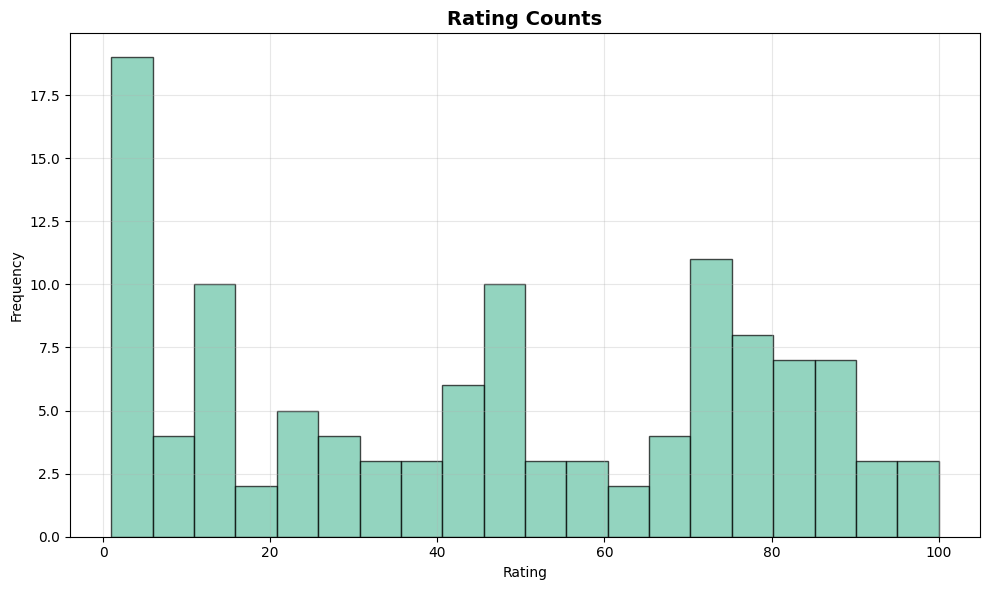

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(responses_df["rating"], bins=20, edgecolor="black", alpha=0.7, color=colours[0])
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("Rating Counts", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluation of Inter-Rater Reliability

In [12]:
#pivot to get table and calculate k-alpha
k_alpha_table = responses_df.pivot(index="respondent_id", columns="pair_id", values="rating")
ka = krippendorff.alpha(k_alpha_table.values, level_of_measurement="interval")
print(f"Krippendorff's Alpha: {ka:.2f}")

Krippendorff's Alpha: 0.52


## Observations

The boxplot clearly visualises how much human ratings vary across most pairs. This is to be expected as α = 0.52. Most boxes are long, indicating a wide range of ratings, although there are some noteable outliers:

- Pair 5 has a strong consensus around very low alignment - this pair was specifically chosen as a very clear bad match. 
- Having looked into pair 8, I can see that this is a single-beneficiary funder. The fact that it received a score above 80 suggests that perhaps a rater missed that restriction.
- As the barchart shows, there was a greater consensus when it came to lower scores. It is evident that it is easier to interpret indicators of a very bad match; Pair 10, which has one of the largest ranges of scores, was actually well-matched due to a previous grants relationship although the funder states 'No Unsolicited Applications'. This highlights that a single piece of information can make the difference between a good and bad match - and if different raters spot or overlook different pieces of critical information, their scores will diverge significantly.

This highlights a limitation of my evaluation approach: raters were given the same information that prospie has access to, but did not all make the same observations. These results further confirm that prospecting is not an exact science with objectively "correct" answers, but rather a nuanced judgement task where having access to transparent reasoning will potentially be substantially more important than receiving one single score. 

-----

# Comparison of prospie Scores and Rater Scores

I will now calculate and display the prospie scores for the evaluation pairs. I will then create a scatterplot to visualise the relationship between the prospie scores and the means of the raters' scores, calculating Pearson's coefficient to understand the strength of any correlation.

In [13]:
#get scores for all pairs and display
for idx, row in eval_df.iterrows():
    result_v2 = calculate_alignment_score(eval_df, idx, grants_df, areas_df, hierarchies_df, model)
    format_tests(idx, row, result_v2)

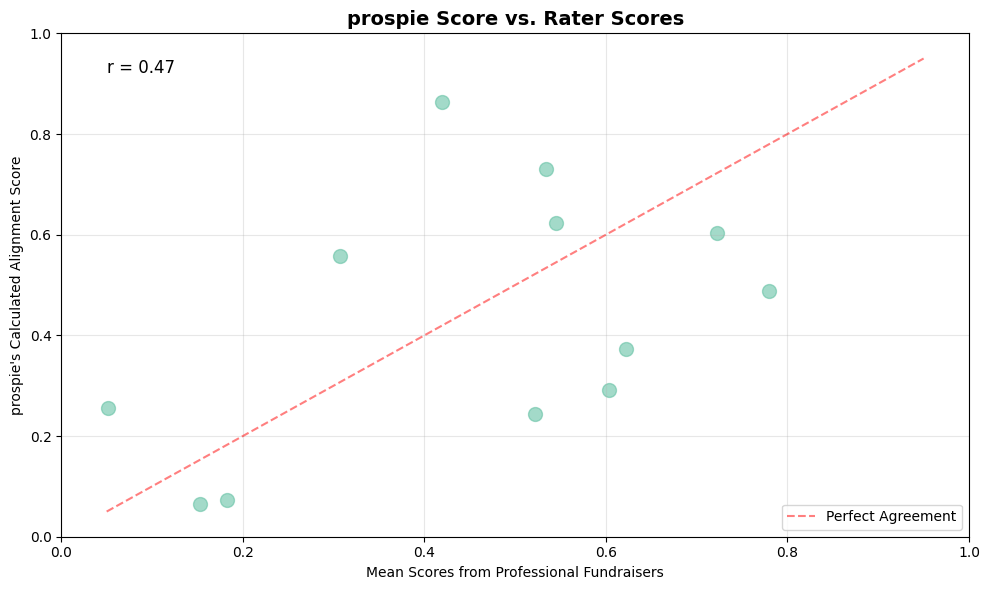

In [14]:
#store calculated scores
eval_df["calculated_score"] = eval_df.apply(
    lambda row: calculate_alignment_score(
        eval_df,
        row.name,
        grants_df,
        areas_df,
        hierarchies_df,
        model
    ),
    axis=1
)

#find mean rater scores and add to df
mean_ratings = responses_df.groupby("pair_id")["rating"].mean().reset_index()
mean_ratings.columns = ["id", "mean_rating"]
comparison_df = eval_df[["id", "calculated_score"]].merge(mean_ratings, on="id", how="inner")

#normalise mean rater scores
comparison_df["mean_rating_norm"] = ((comparison_df["mean_rating"] - 1) / 99) * 0.90 + 0.05

#create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(comparison_df["mean_rating_norm"], comparison_df["calculated_score"], alpha=0.6, s=100, color=colours[0])

#get pearsons r
corr = comparison_df["mean_rating_norm"].corr(comparison_df["calculated_score"])
plt.text(0.05, 0.95, f'r = {corr:.2f}', transform=plt.gca().transAxes,
        fontsize=12, verticalalignment="top")

#add labels
plt.xlabel("Mean Scores from Professional Fundraisers")
plt.ylabel("prospie's Calculated Alignment Score")
ax.set_title("prospie Score vs. Rater Scores", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)

#add line
plt.plot([0.05, 0.95], [0.05, 0.95], "r--", alpha=0.5, label="Perfect Agreement")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Observations

The scatter plot shows a moderate positive correlation (r=0.47) between prospie's scores and the mean human ratings. Most pairs cluster reasonably near the line of perfect agreement, with both prospie and the human raters performing particularly well at identifying poor matches (bottom left cluster). The correlation of 0.47 is actually quite reasonable given that the raters only achieved α = 0.52 agreement with each other. Looking at this knowing the full context of each pair, prospie's scores generally reflect what I would expect - which suggests that it is applying the criteria more consistently than human raters who may have overlooked key details or rushed through the evaluation.

----

# Validation of Scores with Historical Data

## Test 1: Full Calculation

I will use the historical grants data in my database to create a validation set of funder-recipient pairs to test the accuracy of my alignment score calculation.

First, I will create a sample of recent funders (from the past 10 years) who have given at least 20 grants.

In [15]:
#get sample
recent_sample = grants_df[grants_df["year"] >= 2015]
grant_counts = recent_sample.groupby("funder_num").size()
recent_funders = grant_counts[grant_counts >= 20].index.tolist()
recent_grants = recent_sample[recent_sample["funder_num"].isin(recent_funders)]

print(f"Eligible funders: {len(recent_funders)}")
print(f"Eligible grants: {len(recent_grants):,}")

Eligible funders: 155
Eligible grants: 26,367


There are 155 eligible funders, who since 2015 have given a combined total of 26,367 grants. It would be too computationally expensive to calculate scores for all of these pairs, so I will use a random 10% sample of 2,636 pairs. I will exclude recipients that have been pulled from accounts without matching an existing registered charity, as they have the most missing data and do not, therefore, represent a comprehensive proxy of the data that a user will enter about their own charity (so do not offer as much value in testing the power and accuracy of the model).

I will then combine the reduced `grants_df` with the relevant rows in `funders_df` to create the validation dataframe, before calling `calculate_alignment_score()` for each pair.

In [16]:
#get sample
grants_excluding_extracted = recent_grants[recent_grants["recipient_id"].astype(str).str[0].str.isdigit()]
validation_sample = grants_excluding_extracted.sample(n=2636, random_state=42)

#merge with funders
validation_df = validation_sample.merge(
    funders_df,
    left_on="funder_num",
    right_on="registered_num",
    how="inner"
)

#rename cols to match required format
validation_df = validation_df.rename(columns={"registered_num": "funder_registered_num"})
validation_df = validation_df.rename(columns=lambda col: f"user_{col[len('recipient_'):]}" if col.startswith("recipient_") else col)
validation_df = validation_df.rename(columns={"recipient_id": "user_id"})

In [17]:
#calculate scores for validation pairs
results = []

for idx, row in validation_df.iterrows():
    score = calculate_alignment_score(
        validation_df,
        idx,
        grants_df,
        areas_df,
        hierarchies_df,
        model
    )

    #store results
    results.append({
        "funder_num": row["funder_num"],
        "recipient_id": row["user_id"],
        "prospie_score": score,
        "actual_grant_amount": row["amount"],
        "year": row["year"]
    })

    #progress checkpoints
    if (len(results) % 200 == 0):
        print(f"Calculated {len(results)} scores")

Calculated 200 scores
Calculated 400 scores
Calculated 600 scores
Calculated 800 scores
Calculated 1000 scores
Calculated 1200 scores
Calculated 1400 scores
Calculated 1600 scores
Calculated 1800 scores
Calculated 2000 scores
Calculated 2200 scores
Calculated 2400 scores
Calculated 2600 scores


In [18]:
#get df of results and view stats
results_df = pd.DataFrame(results)
print(f"{results_df['prospie_score'].describe().round(2)}")

count    2636.00
mean        0.83
std         0.17
min         0.05
25%         0.71
50%         0.95
75%         0.95
max         0.95
Name: prospie_score, dtype: float64


In [19]:
#view proportion of scores above thresholds
print(f"Proportion scoring >50%: {(results_df['prospie_score'] > 0.5).mean():.2%}")
print(f"Proportion scoring >60%: {(results_df['prospie_score'] > 0.6).mean():.2%}")
print(f"Proportion scoring >70%: {(results_df['prospie_score'] > 0.7).mean():.2%}")

#view overall averages
print(f"Mean: {results_df['prospie_score'].mean():.2f}")
print(f"Median: {results_df['prospie_score'].median():.2f}")
print(f"Mode: {results_df['prospie_score'].mode()[0]:.2f}")

Proportion scoring >50%: 93.17%
Proportion scoring >60%: 83.50%
Proportion scoring >70%: 75.95%
Mean: 0.83
Median: 0.95
Mode: 0.95


Scores at 0.95 cap: 1450 (55.0%)


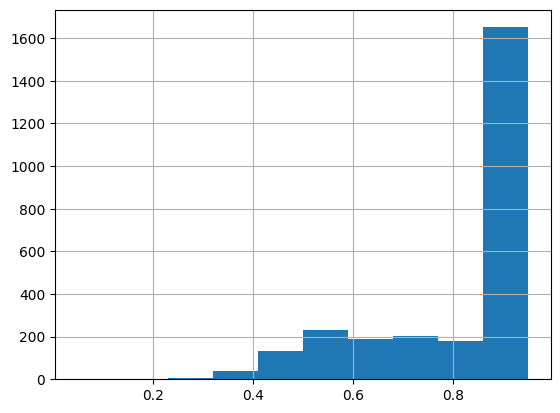

In [20]:
#consider maximum scorers
num_95 = (results_df["prospie_score"] == 0.95).sum()
pct_95 = (results_df["prospie_score"] == 0.95).mean()
print(f"Scores at 0.95 cap: {num_95} ({pct_95:.1%})")

results_df["prospie_score"].hist(bins=10);

### Observations

Looking at these scores, I notice that the mode is 0.95, and as the histogram shows, there is a large peak at pairs scoring 0.95 (representing 55% of the sample). This is expected as the validation dataset consists of funder-recipient pairs where grants were actually awarded, so many will have existing relationships that trigger the relationship bonus multiplier. To better understand the contribution of different components, I will run the validation again but this time exclude the existing relationship bonus. 

## Test 2: Calculation without Relationship Bonus